# Temporal and Spatial Smoothing

This demo demonstrates `climpred`'s capabilities to postprocess decadal prediction output before skill verification.
Here, we showcase a set of methods to smooth out noise in the spatial and temporal domain.

In [19]:
import warnings
%matplotlib inline
from climpred import PerfectModelEnsemble, HindcastEnsemble
from climpred.tutorial import load_dataset
import matplotlib.pylab as plt
warnings.filterwarnings("ignore")

In [2]:
# Sea surface temperature
v='tos'
ds3d = load_dataset('MPI-PM-DP-3D')[v]
control3d = load_dataset('MPI-control-3D')[v]

`climpred` requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years,seasons,months,weeks,pentads,days`.  For the this data, the `lead` `units` are `years`. 

In [3]:
ds3d['lead'].attrs={'units': 'years'}

## Temporal smoothing

In order to reduce temporal noise, decadal predictions are recommended to take multi-year averages [Goddard2013].

In [4]:
pm = PerfectModelEnsemble(ds3d)
pm = pm.add_control(control3d)

`PredictionEnsemble.smooth({'lead':x})` aggregates over `x` timesteps in time dimensions `lead` and `time`. Here it does not matter whether you specify `lead` or `time`, temporal smoothing is applied to both time dimensions. Note that the time dimension labels are not changed by this temporal smoothing.

In [6]:
pm_tsmoothed = pm.smooth({'lead':3})
print('initialized', pm_tsmoothed.get_initialized().coords,'\n')
print('control',pm_tsmoothed.get_control().coords)

initialized Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * lead     (lead) int64 1 2 3
  * init     (init) object 3014-01-01 00:00:00 ... 3237-01-01 00:00:00
  * member   (member) int64 1 2 3 4 

control Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * time     (time) object 3000-01-01 00:00:00 ... 3047-01-01 00:00:00


But after calling `compute_metric()` or `verify()`, the correct time aggregation label is automatically set.

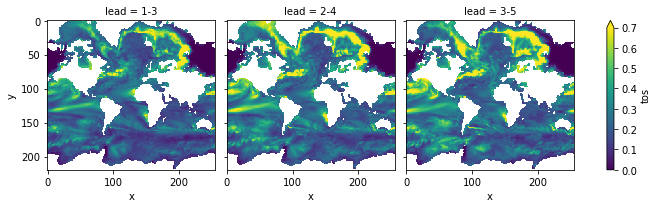

In [7]:
pm_tsmoothed.compute_metric(metric='rmse', comparison='m2e')[v].plot(col='lead', vmin=0, vmax=.7, yincrease=False)

Compare to the prediction skill without smoothing:

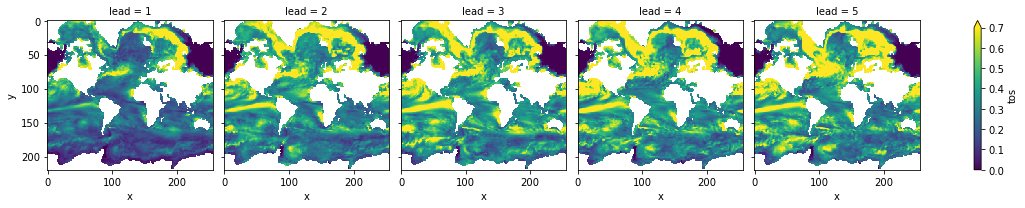

In [8]:
pm.compute_metric(metric='rmse', comparison='m2e')[v].plot(col='lead', vmin=0, vmax=.7, yincrease=False)

You can plot time-aggregated skill timeseries by specifying `x=lead_center` while plotting. Lead centers are placed in the center of the lead-aggregation boundaries. Note how the correlation of forecasts is increasing for longer time-aggregations because noise is smoothed out.

In [40]:
pm_NA = PerfectModelEnsemble(load_dataset('MPI-PM-DP-1D').tos)
pm_NA = pm_NA.add_control(load_dataset('MPI-control-1D').tos)
pm_NA = pm_NA.sel(area='North_Atlantic_SPG',period='DJF')

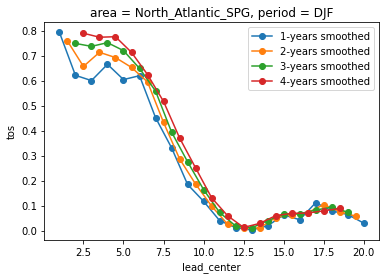

In [42]:
for time_agg in [1,2,3,4]:
    pm_NA.smooth({'lead':time_agg}).compute_metric(metric='acc').tos.plot(
        x='lead_center', marker='o',label=f'{time_agg}-years smoothed')
plt.legend()

In [16]:
# HindcastEnsemble example
v='SST'
hind = load_dataset('CESM-DP-SST-3D')[v]
reconstruction = load_dataset('FOSI-SST-3D')[v]
# get anomaly reconstruction
reconstruction = reconstruction - reconstruction.mean('time')

In [17]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(reconstruction, 'reconstruction')

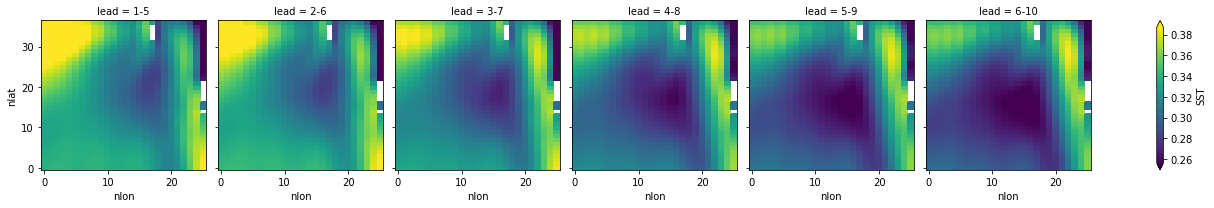

In [18]:
hindcast.smooth({'lead':5}).verify(metric='rmse', comparison='e2r')[v].plot(col='lead', robust=True)

## Spatial smoothing
In order to reduce spatial noise, global decadal predictions are recommended to get regridded to a 5 degree longitude x 5 degree latitude grid as recommended [Goddard2013].

In [19]:
v='tos'
pm_ssmoothed = pm.smooth({'lon':5,'lat':5})
pm_ssmoothed.get_initialized().coords

Reuse existing file: bilinear_220x256_36x73.nc
Reuse existing file: bilinear_220x256_36x73.nc


Coordinates:
  * lead     (lead) int64 1 2 3 4 5
  * init     (init) object 3014-01-01 00:00:00 ... 3237-01-01 00:00:00
  * member   (member) int64 1 2 3 4
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
  * lat      (lat) float64 -83.97 -78.97 -73.97 -68.97 ... 81.03 86.03 91.03

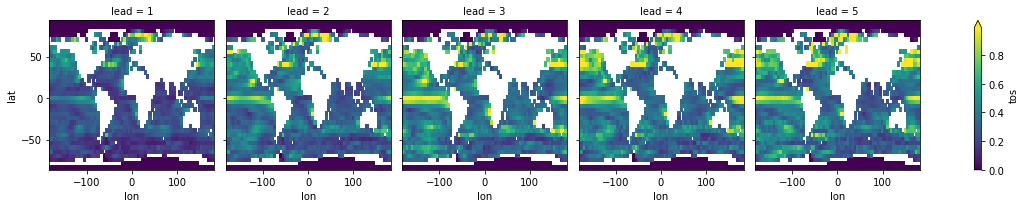

In [20]:
pm_ssmoothed.compute_metric(metric='rmse', comparison='m2e')[v].plot(col='lead', robust=True, yincrease=True)

Spatial smoothing guesses the names corresponding to `lon` and `lat` in the coordinates of the `PredictionEnsemble` underlying datasets.

In [24]:
hindcast.get_initialized().coords

Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * init     (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
    TAREA    (nlat, nlon) float64 ...

In [28]:
hindcast.smooth({'lon':1,'lat':1}).get_initialized().coords

Reuse existing file: bilinear_37x26_11x30.nc
Reuse existing file: bilinear_37x26_11x30.nc


Coordinates:
  * init     (init) object 1954-01-01 00:00:00 ... 2017-01-01 00:00:00
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
  * lon      (lon) float64 250.8 251.8 252.8 253.8 ... 276.8 277.8 278.8 279.8
  * lat      (lat) float64 -9.75 -8.75 -7.75 -6.75 ... -1.75 -0.7503 0.2497

`PredictionEnsemble.smooth(goddard2013)` creates 4-year means and 5x5 degree regridding as suggested in [Goddard2013].

In [21]:
pm.smooth('goddard2013').compute_metric(metric='acc',comparison='m2e').coords

Reuse existing file: bilinear_220x256_36x73.nc
Reuse existing file: bilinear_220x256_36x73.nc


Coordinates:
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
  * lat      (lat) float64 -83.97 -78.97 -73.97 -68.97 ... 81.03 86.03 91.03
  * lead     (lead) <U3 '1-4' '2-5'

## References

1. Goddard, L., A. Kumar, A. Solomon, D. Smith, G. Boer, P. Gonzalez, V. Kharin, et al. “A Verification Framework for Interannual-to-Decadal Predictions Experiments.” Climate Dynamics 40, no. 1–2 (January 1, 2013): 245–72. https://doi.org/10/f4jjvf.
